# Configuration

In [1]:
%load_ext autoreload
%autoreload 2

## Read packages

In [ ]:
import json, math, random, time, zipfile, io
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
import copy

from types import SimpleNamespace
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import optuna

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torchvision import transforms, models
from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

from dataclasses import dataclass, field

import os
import sys
import warnings

# To ignore warnings from albumentations
warnings.filterwarnings("ignore")
os.environ["ALBUMENTATIONS_DISABLE_VERSION_CHECK"] = "1"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

sys.path.append("..")

from src.data_utils import *
from src.cnn_models import *
from src.training_utils import *
from src.evaluation_utils import *

Device: cpu


## Read data-images

In [3]:
filename = "cnn_personalized.ipynb"  # Name of current file
print(f"Current absolute path: {os.getcwd()}\n")

# We specify the path of the current directory and the data and output directories.
ACTUAL_DIR = os.path.dirname(os.path.abspath(filename))
BASE_DIR = os.path.dirname(ACTUAL_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
IMG_DIR = os.path.join(DATA_DIR, "images")
OUTPUT_DIR = os.path.join(DATA_DIR, "output")

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"IMG_DIR: {IMG_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

Current absolute path: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/notebooks

BASE_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA
DATA_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/data
IMG_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/data/images
OUTPUT_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendi

In [4]:
# Read the CSV file
csv_file = os.path.join(DATA_DIR, "train.csv")
df_train_complete = pd.read_csv(csv_file)

## Init params
Base parameters and classes to use downstream.

In [5]:
# Data related params
prct_train = 0.8
img_size = 256
weight_cap = 5  # for positive weight, to avoid too large weights


# Class related params
@dataclass
class TrainConfig:
    img_size: int = 256
    batch_size: int = 16
    epochs: int = 10
    lr: float = 1e-4  # Learning rate
    weight_decay: float = 1e-4  # Weight decay for optimizer
    positive_weight: float = 1.0  # Weight for positive class in classification loss
    cls_loss_w: float = 1.0  # Weight for classification loss
    box_loss_w: float = 2.0  # Weight for bounding box loss
    beta_smoothl1: float = 1.0  # beta parameter for SmoothL1Loss
    es_patience: int = 5  # Early stopping patience
    monitor: str = "val_iou"  # "val_loss" | "val_iou" | "val_score"
    alpha_score: float = 0.7  # If use "val_score": score = alpha*IoU + (1-alpha)*ACC
    cnn_name: str = "cnn"  # Name of the CNN model
    output_dir: str = OUTPUT_DIR  # Directory to save models and logs
    logging_step: int = 5  # For logging every n steps
    verbose: bool = True  # Whether to print logs

# Prepare data
Divide train and valid data.  
Build the Datasets objects.

In [6]:
# Compute the weight of positive classes.
# This will be useful whether the df is desbalanced
# and for downstream training tasks

# Use a weight cap to avoid too large weights

if DEFAULT_COLS["class"] in df_train_complete.columns:
    # Calculate class counts
    counts = (
        df_train_complete[DEFAULT_COLS["class"]]
        .str.lower()
        .map(CLASS_TO_LABEL)
        .value_counts()
    )
    print("Class counts:", counts.to_dict())

    # Calculate pos_weight
    pos = float(counts.get(1, 1.0))
    neg = float(counts.get(0, 1.0))
    positive_weight = torch.tensor(
        [min(weight_cap, max(1.0, neg / max(1.0, pos)))], device=DEVICE
    )
    print("Calculated positive_weight:", positive_weight.item())
else:
    print(
        "Warning: 'class' column not found in DataFrame. Skipping pos_weight calculation."
    )

Class counts: {0: 135, 1: 84}
Calculated positive_weight: 1.6071428060531616


In [7]:
# split the data into train and valid
n = len(df_train_complete)
n_train = math.floor(prct_train * n)
n_valid = n - n_train

# Shuffle and split
df_shuffled = df_train_complete.sample(frac=1, random_state=42).reset_index(drop=True)
df_valid = df_shuffled.iloc[n_train:].reset_index(drop=True)
df_train = df_shuffled.iloc[:n_train].reset_index(drop=True)

print(f"Total samples: {n}, Train samples: {n_train}, Validation samples: {n_valid}")

Total samples: 219, Train samples: 175, Validation samples: 44


In [8]:
## Build the Datasets
# In this case, we will use personalized normalization

# Compute the mean and std per channel (R, G, B) across all training images
mean_train_images, std_train_images = compute_mean_std_image_dir(
    IMG_DIR, df_train["filename"].tolist()
)

# Create the datasets with personalized normalization
train_dataset = MaskDataset(
    df=df_train,
    images_dir=IMG_DIR,
    img_size=img_size,
    personalized_norm=True,
    custom_mean=mean_train_images,
    custom_std=std_train_images,
)

# Use the same normalization of training to avoid data leakage
valid_dataset = MaskDataset(
    df=df_valid,
    images_dir=IMG_DIR,
    img_size=img_size,
    personalized_norm=True,
    custom_mean=mean_train_images,
    custom_std=std_train_images,
)

# Base CNN 
Evaluate a basic backbone + basic decision head.  

In [9]:
# Base CNN architecture params
base_ch = 16  # base number of channels
out_dim = 128  # output feature dimension from the backbone
prct_dropout = 0.3  # dropout percentage

# Base training params
lr_base = 1e-4
weight_decay_base = 1e-4

# Instantiate the base model
base_backbone = BaseBackbone(base_ch=base_ch, out_dim=out_dim)

# Wrap the backbone and add the decision head
base_cnn_arch = TwoHeadNetVOC(
    backbone=base_backbone, feat_dim=out_dim, dropout=prct_dropout
).to(DEVICE)

# Define the optimizer and the accuracy metric
optimizer = torch.optim.AdamW(
    base_cnn_arch.parameters(), lr=lr_base, weight_decay=weight_decay_base
)
acc_metric = BinaryAccuracy().to(DEVICE)

# Model summary
summary(base_cnn_arch, (3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                  [-1, 128]           8,320
      BaseBackbone-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
           Linear-14                   

In [ ]:
# Define the configuration dictionary
cfg = TrainConfig(
    img_size=img_size,
    batch_size=16,
    epochs=50,
    lr=lr_base,
    es_patience=5,
    cls_loss_w=1.0,
    box_loss_w=1.5,
    monitor="val_score",  # options: "val_loss", "val_iou", "val_score"
    positive_weight=None,
    cnn_name="cnn_base",
)

# Instantiate the trainer
base_model = Trainer_base(
    base_cnn_arch,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    optimizer=optimizer,
    cfg=cfg,
    device=DEVICE,
)

# Start the training
history_base_model = base_model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(base_model)

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.6259, acc: 0.611, IoU: 0.000 | Valid -- loss: 1.6237, acc: 0.659, IoU: 0.000 | Monitor(val_score): 0.1977
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.5919, acc: 0.606, IoU: 0.003 | Valid -- loss: 1.5804, acc: 0.659, IoU: 0.006 | Monitor(val_score): 0.2021
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.2808, acc: 0.600, IoU: 0.274 | Valid -- loss: 1.2396, acc: 0.659, IoU: 0.295 | Monitor(val_score): 0.4044
Epoch 015 | LR 1.00e-04 | Train -- loss: 1.2555, acc: 0.600, IoU: 0.304 | Valid -- loss: 1.2301, acc: 0.659, IoU: 0.307 | Monitor(val_score): 0.4128

Early stopping at epoch 17:

Best val_score: 0.4176
Train: loss: 1.2724, acc: 0.594, IoU: 0.285
Valid: loss: 1.2321, acc: 0.659, IoU: 0.310
Best val_score: 0.4176
Train: loss: 1.2724, acc: 0.594, IoU: 0.285
Valid: loss: 1.2321, acc: 0.659, IoU: 0.310

----------
Sanity check on a batch of validation data:
Targets [0,1] min/max/mean: (0.08749999850988388, 0.99609375, 0.5147460699081421)
Preds   [0,1] 

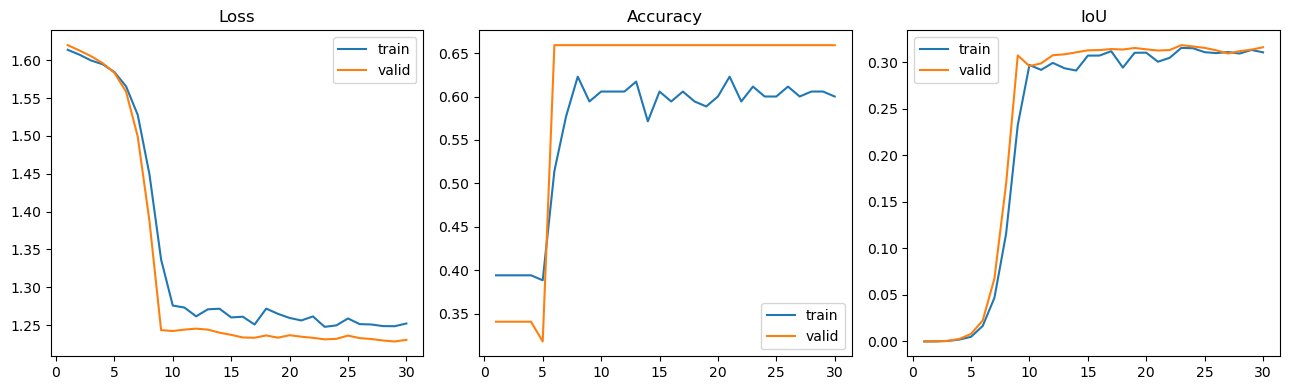

In [71]:
# Plot the training history
plot_history(history_base_model, figsize=(13, 4))

# of images selected: 5


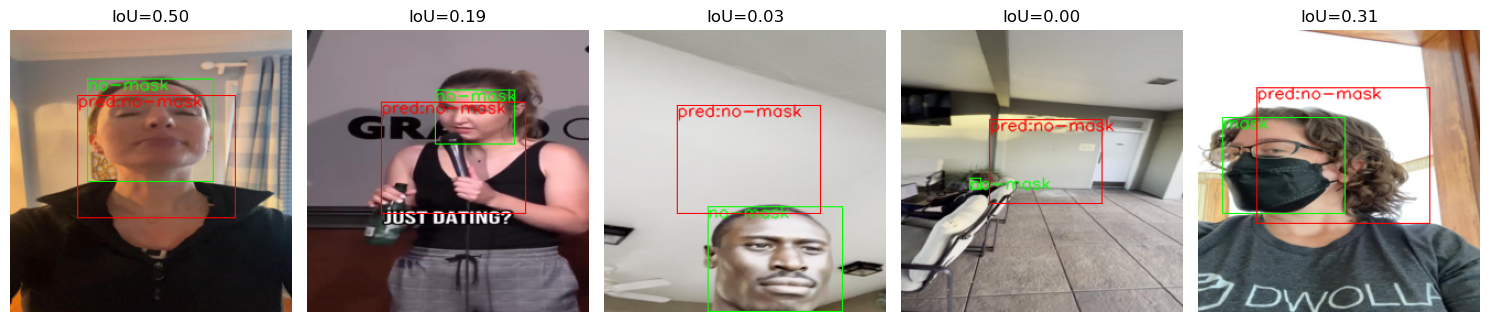

In [11]:
# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_base", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=base_cnn_arch,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [ ]:
# Free up memory
del base_model
del base_cnn_arch
del optimizer  # delete when declared out of the trainer class

try:
    torch.cuda.empty_cache()
except:
    pass

We can note that the classification task is not working correctly, nor is the regression task.  
**This base model is very deficient**, and from this point on, the goal is to continue improving the performance of our convolutional neural network.

# Tunning the base model

## Improve the backbone architecture
Tests with different hidden layers distribution and useful modules

### Backbone #2 - lite

- Lighter architecture, only 2 convolutional layers, global avg pooling (1) and dropout in both backbone and desicion head.  
- Use the same configuration of base example.

In [13]:
# Lite backbone - Smaller and faster
backbone_simple = liteBackbone(base_ch=16, out_dim=128, dropout=0.5)
cnn_arch_2 = TwoHeadNetVOC(backbone=backbone_simple, feat_dim=128, dropout=0.3).to(
    DEVICE
)

# Optimizer and accuracy metric instantiate inside the Trainer class

# Define the configuration dictionary - same as base configuration
cfg2 = cfg
cfg2.cnn_name = "cnn_simple"

# Model summary
summary(cnn_arch_2, (3, cfg2.img_size, cfg2.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
              ReLU-4           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-5             [-1, 32, 1, 1]               0
           Flatten-6                   [-1, 32]               0
           Dropout-7                   [-1, 32]               0
            Linear-8                  [-1, 128]           4,224
      liteBackbone-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
           Linear-14                   

In [14]:
# Instantiate the trainer - same datasets
model = Trainer_base(
    cnn_arch_2,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    cfg=cfg2,
    device=DEVICE,
)

# Start the training
history_model_cnn_lite = model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(model)

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.6186, acc: 0.560, IoU: 0.000 | Valid -- loss: 1.6166, acc: 0.659, IoU: 0.000 | Monitor(val_score): 0.1977
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.5887, acc: 0.600, IoU: 0.004 | Valid -- loss: 1.5839, acc: 0.659, IoU: 0.005 | Monitor(val_score): 0.2013
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.4138, acc: 0.606, IoU: 0.153 | Valid -- loss: 1.3573, acc: 0.659, IoU: 0.208 | Monitor(val_score): 0.3436
Epoch 015 | LR 1.00e-04 | Train -- loss: 1.2831, acc: 0.600, IoU: 0.273 | Valid -- loss: 1.2511, acc: 0.659, IoU: 0.298 | Monitor(val_score): 0.4060

Early stopping at epoch 19:

Best val_score: 0.4069
Train: loss: 1.2655, acc: 0.611, IoU: 0.287
Valid: loss: 1.2461, acc: 0.659, IoU: 0.298

----------
Sanity check on a batch of validation data:
Targets [0,1] min/max/mean: (0.0, 0.99609375, 0.48237305879592896)
Preds   [0,1] min/max/mean: (0.127168670296669, 0.8665384650230408, 0.4706769585609436)
IoU mean (Random batch): 0.2183731323457323


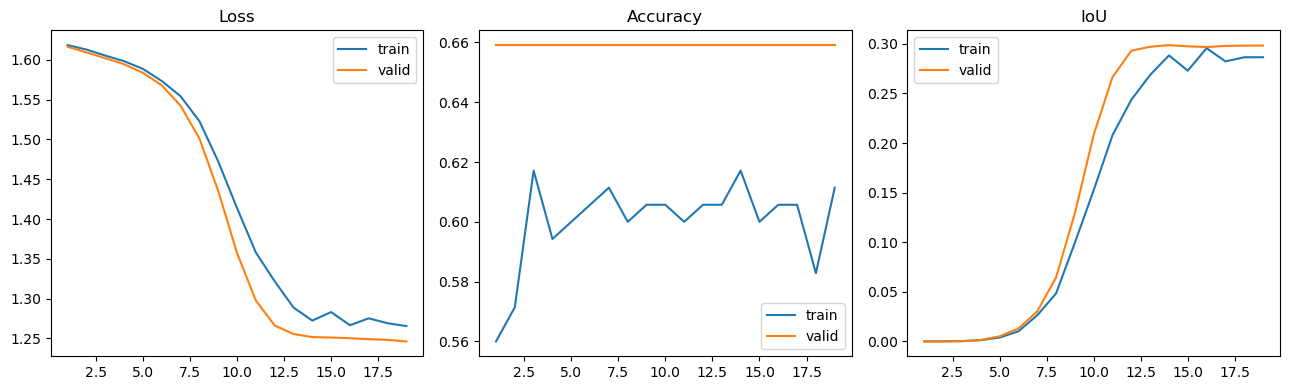

# of images selected: 5


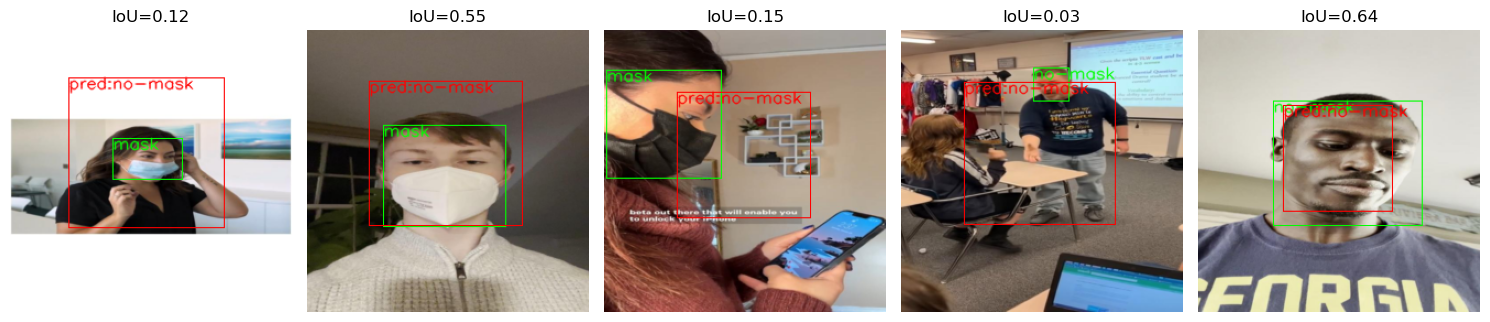

In [15]:
# Plot the training history
plot_history(history_model_cnn_lite, figsize=(13, 4))


# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_simple", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=cnn_arch_2,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [ ]:
# Free up memory
del model
del cnn_arch_2

try:
    torch.cuda.empty_cache()
except:
    pass

### Backbone #3 - Robust

- Deeper architecture: multiple convolution → batch norm → ReLU blocks, with progressive channel increase (c → 2c → 4c).
- **Stride convolutions** instead of max pooling.
- **Batch Normalization** after each convolution.
- AdaptiveAvgPool2d(g_pool) → **global average pooling**, outputs a fixed-size feature vector regardless of input image size.  
Output with size g_pool x g_pool to retain some spacial information.
- Dropout after global pooling.
- Use the same configuration of base example.

In [18]:
# Lite backbone - Smaller and faster
backbone_robust = RobustBackbone(base_ch=16, out_dim=256, dropout=0.5, g_pool=3)
cnn_arch_3 = TwoHeadNetVOC(backbone=backbone_robust, feat_dim=256, dropout=0.3).to(
    DEVICE
)

# Optimizer and accuracy metric instantiate inside the Trainer class (using cfg)

# Define the configuration dictionary - same as base configuration
cfg3 = cfg
cfg3.cnn_name = "cnn_robust"

# Model summary
summary(cnn_arch_3, (3, cfg3.img_size, cfg3.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7           [-1, 32, 64, 64]           4,608
       BatchNorm2d-8           [-1, 32, 64, 64]              64
              ReLU-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           9,216
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]          18,432
      BatchNorm2d-14           [-1, 64,

In [19]:
# Instantiate the trainer - same datasets
model = Trainer_base(
    cnn_arch_3,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    cfg=cfg3,
    device=DEVICE,
)

# Start the training
history_model_cnn_robust = model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(model)

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.5573, acc: 0.611, IoU: 0.016 | Valid -- loss: 1.5961, acc: 0.659, IoU: 0.001 | Monitor(val_score): 0.1983
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.1228, acc: 0.686, IoU: 0.338 | Valid -- loss: 1.1150, acc: 0.659, IoU: 0.340 | Monitor(val_score): 0.4355
Epoch 010 | LR 1.00e-04 | Train -- loss: 0.9344, acc: 0.846, IoU: 0.353 | Valid -- loss: 0.9537, acc: 0.750, IoU: 0.365 | Monitor(val_score): 0.4805
Epoch 015 | LR 1.00e-04 | Train -- loss: 0.8296, acc: 0.869, IoU: 0.358 | Valid -- loss: 0.9756, acc: 0.795, IoU: 0.353 | Monitor(val_score): 0.4856
Epoch 020 | LR 1.00e-04 | Train -- loss: 0.7618, acc: 0.926, IoU: 0.367 | Valid -- loss: 0.8419, acc: 0.864, IoU: 0.362 | Monitor(val_score): 0.5123
Epoch 025 | LR 1.00e-04 | Train -- loss: 0.7085, acc: 0.937, IoU: 0.384 | Valid -- loss: 0.8315, acc: 0.909, IoU: 0.377 | Monitor(val_score): 0.5363
Epoch 030 | LR 1.00e-04 | Train -- loss: 0.6857, acc: 0.920, IoU: 0.389 | Valid -- loss: 0.8580, acc: 0.86

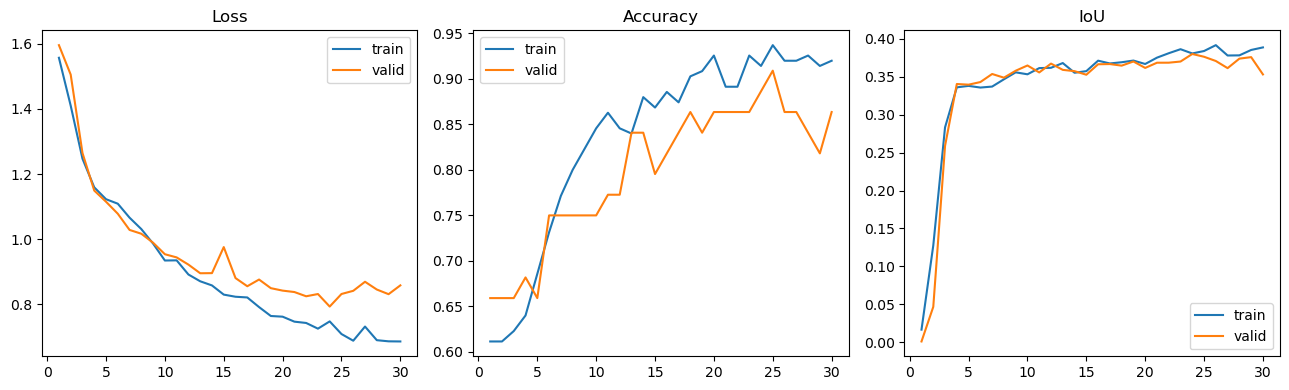

# of images selected: 5


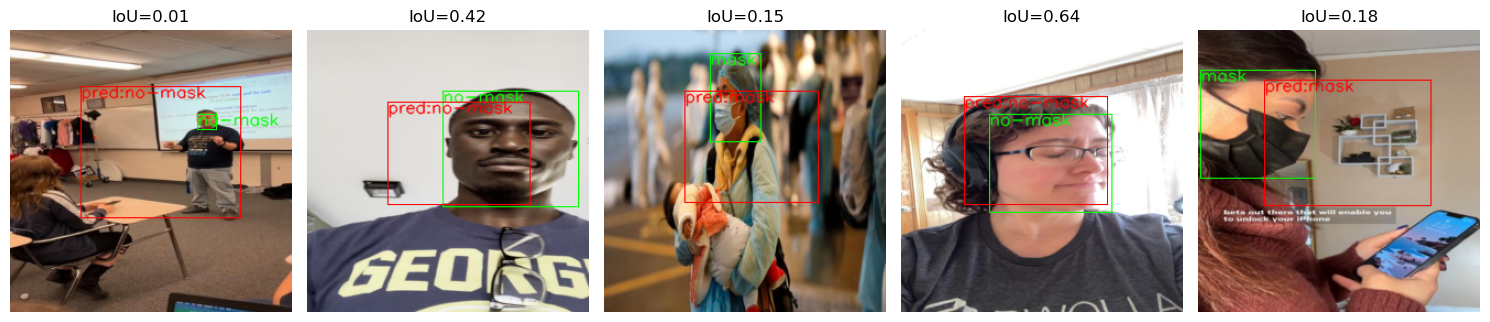

In [21]:
# Plot the training history
plot_history(history_model_cnn_robust, figsize=(13, 4))


# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_robust", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=cnn_arch_3,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [22]:
# Free up memory
del model
del cnn_arch_3

try:
    torch.cuda.empty_cache()
except:
    pass

## Improve the desicion head architecture
Test with more layers or useful modules

### Head decision #2

- Use the same configuration of base example.
- **Deeper classification head** → 3 linear layers with BatchNorm + ReLU + Dropout at each step, instead of a shallow MLP.
- **Convolutional regression head** → the box_head now uses Conv1d to capture local patterns within the feature vector.
- **Normalization & regularization** → every conv/dense block includes BatchNorm and Dropout.
- **Dynamic adaptive pooling on regression head** → AdaptiveAvgPool1d(g_pool_bbox) compresses the feature length to a fixed size,  
making the model scalable to different feat_dim values.

In [70]:
# Robust backbone and improved decision head
feat_dim = 256
backbone = RobustBackbone(base_ch=16, out_dim=feat_dim, dropout=0.5, g_pool=5)
cnn_arch_4 = RobustTwoHeadNetVOC(
    backbone=backbone, feat_dim=feat_dim, dropout=0.25, g_pool_bbox=int(feat_dim / 2)
).to(DEVICE)

# Optimizer and accuracy metric instantiate inside the Trainer class

# Define the configuration dictionary - almost the same as base configuration
cfg4 = cfg
cfg4.es_patience = 8  # reduce patience
cfg4.cnn_name = "cnn_all_robust"
cfg4.monitor = "val_iou"

# Model summary
summary(cnn_arch_4, (3, cfg4.img_size, cfg4.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7           [-1, 32, 64, 64]           4,608
       BatchNorm2d-8           [-1, 32, 64, 64]              64
              ReLU-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           9,216
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]          18,432
      BatchNorm2d-14           [-1, 64,

In [71]:
# Instantiate the trainer - same datasets
model = Trainer_base(
    cnn_arch_4,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    cfg=cfg4,
    device=DEVICE,
)

# Start the training
history_model_cnn_head_robust = model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(model)

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.4462, acc: 0.583, IoU: 0.117 | Valid -- loss: 1.5317, acc: 0.659, IoU: 0.022 | Monitor(val_iou): 0.0215
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.1333, acc: 0.703, IoU: 0.313 | Valid -- loss: 1.1409, acc: 0.773, IoU: 0.269 | Monitor(val_iou): 0.2687
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.0012, acc: 0.829, IoU: 0.330 | Valid -- loss: 0.9949, acc: 0.818, IoU: 0.334 | Monitor(val_iou): 0.3338
Epoch 015 | LR 1.00e-04 | Train -- loss: 0.8960, acc: 0.886, IoU: 0.353 | Valid -- loss: 0.9325, acc: 0.841, IoU: 0.354 | Monitor(val_iou): 0.3540
Epoch 020 | LR 1.00e-04 | Train -- loss: 0.8624, acc: 0.914, IoU: 0.357 | Valid -- loss: 0.8828, acc: 0.864, IoU: 0.378 | Monitor(val_iou): 0.3778
Epoch 025 | LR 1.00e-04 | Train -- loss: 0.8100, acc: 0.903, IoU: 0.380 | Valid -- loss: 0.8759, acc: 0.886, IoU: 0.360 | Monitor(val_iou): 0.3601
Epoch 030 | LR 1.00e-04 | Train -- loss: 0.7782, acc: 0.920, IoU: 0.399 | Valid -- loss: 0.8331, acc: 0.909, IoU: 0.38

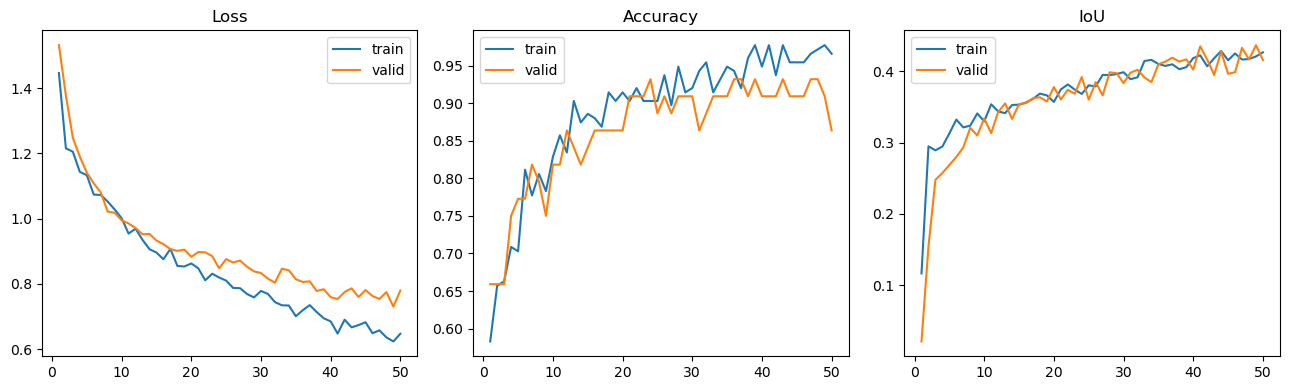

# of images selected: 5


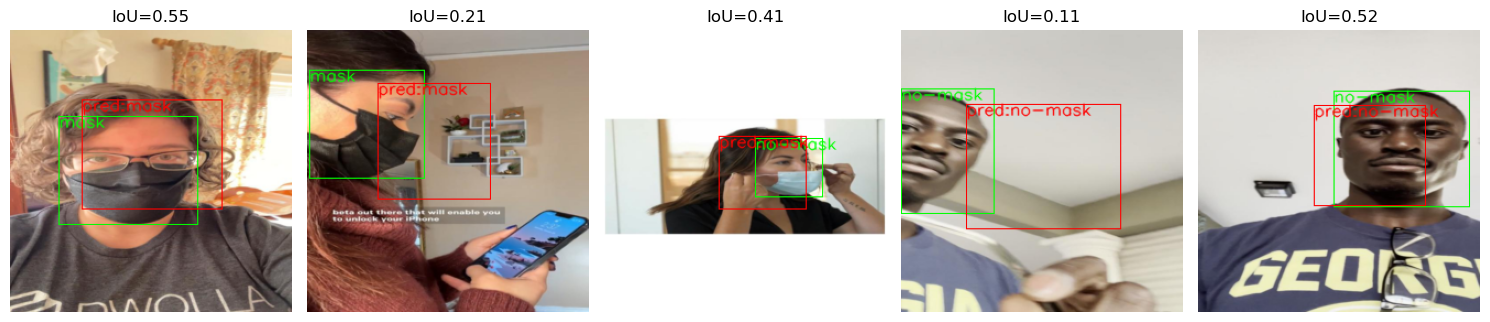

In [80]:
# Plot the training history
plot_history(history_model_cnn_head_robust, figsize=(13, 4))


# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_all_robust", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=cnn_arch_4,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [82]:
# Free up memory
del model
del cnn_arch_4

try:
    torch.cuda.empty_cache()
except:
    pass

### Head decision #3

- Use the same configuration of base example.
- **Deeper classification head** → 3 linear layers with BatchNorm + ReLU + Dropout at each step, instead of a shallow MLP.
- **Deeper regression head** → 3 linear layers with BatchNorm + ReLU + Dropout at each step, instead of a shallow MLP.
- **Normalization & regularization** → every dense block includes BatchNorm and Dropout.

In [59]:
# Robust backbone and improved decision head
feat_dim = 256
backbone = RobustBackbone(base_ch=16, out_dim=feat_dim, dropout=0.5, g_pool=5)
cnn_arch_5 = RobustTwoHeadNetVOC_V2(
    backbone=backbone, feat_dim=feat_dim, dropout=0.3
).to(DEVICE)

# Optimizer and accuracy metric instantiate inside the Trainer class

# Define the configuration dictionary - almost the same as base configuration
cfg5 = cfg
cfg5.es_patience = 8  # reduce patience
cfg5.cnn_name = "cnn_all_robust_v2"
cfg5.monitor = "val_iou"

# Model summary
summary(cnn_arch_5, (3, cfg5.img_size, cfg5.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7           [-1, 32, 64, 64]           4,608
       BatchNorm2d-8           [-1, 32, 64, 64]              64
              ReLU-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           9,216
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]          18,432
      BatchNorm2d-14           [-1, 64,

In [60]:
# Instantiate the trainer - same datasets
model = Trainer_base(
    cnn_arch_5,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    cfg=cfg5,
    device=DEVICE,
)

# Start the training
history_model_cnn_head_robust_v2 = model.fit()

# Sanity check
print(f"\n{'-'*10}\nSanity check on a batch of validation data:")
sanity_check_batch(model)

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.6502, acc: 0.491, IoU: 0.006 | Valid -- loss: 1.5907, acc: 0.659, IoU: 0.003 | Monitor(val_iou): 0.0028
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.4437, acc: 0.720, IoU: 0.024 | Valid -- loss: 1.4343, acc: 0.682, IoU: 0.040 | Monitor(val_iou): 0.0405
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.2489, acc: 0.794, IoU: 0.103 | Valid -- loss: 1.3111, acc: 0.727, IoU: 0.083 | Monitor(val_iou): 0.0835
Epoch 015 | LR 1.00e-04 | Train -- loss: 1.0720, acc: 0.823, IoU: 0.226 | Valid -- loss: 1.1614, acc: 0.773, IoU: 0.187 | Monitor(val_iou): 0.1866
Epoch 020 | LR 1.00e-04 | Train -- loss: 0.9222, acc: 0.851, IoU: 0.321 | Valid -- loss: 0.9928, acc: 0.818, IoU: 0.337 | Monitor(val_iou): 0.3374
Epoch 025 | LR 1.00e-04 | Train -- loss: 0.8569, acc: 0.891, IoU: 0.335 | Valid -- loss: 0.9506, acc: 0.841, IoU: 0.367 | Monitor(val_iou): 0.3674
Epoch 030 | LR 1.00e-04 | Train -- loss: 0.8277, acc: 0.897, IoU: 0.360 | Valid -- loss: 0.9124, acc: 0.841, IoU: 0.38

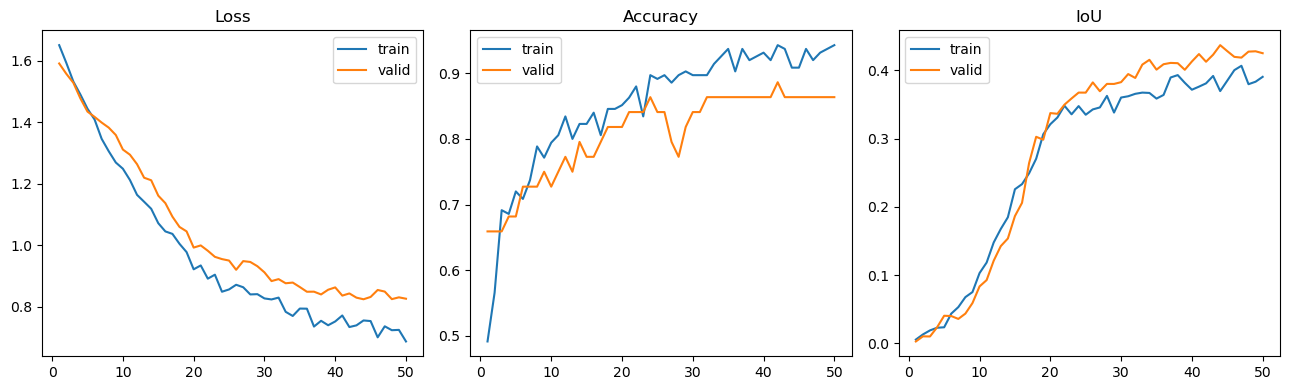

# of images selected: 5


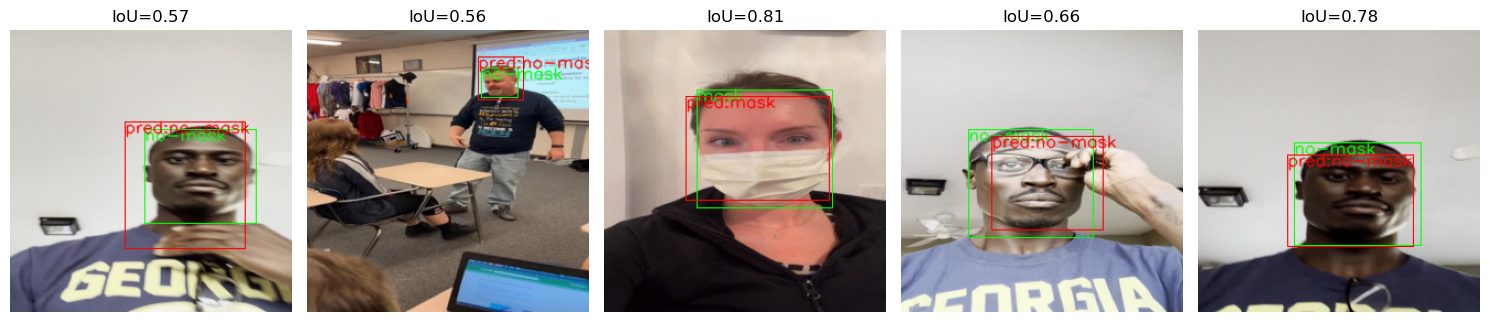

In [61]:
# Plot the training history
plot_history(history_model_cnn_head_robust_v2, figsize=(13, 4))


# Show an inference example by loading the best model and visualizing some predictions
# on random validation images

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_all_robust_v2", "best_monitor_model.pt")
annotations_dict = {"origin": "closed", "thickness": 1, "font_scale": 0.5}

visualize_predictions(
    model_class=cnn_arch_5,  # your network class
    checkpoint_path=checkpoint_path,  # path to the .pt file
    norm_mean=mean_train_images,  # mean for normalization (R, G, B)
    norm_std=std_train_images,  # std for normalization (R, G, B)
    valid_dataset=valid_dataset,  # validation Dataset
    figsize=(15, 5),  # figure size
    annotations_dict=annotations_dict,  # annotations dictionary
    n_images=5,  # number of images to display
    n_cols=5,  # number of columns in the grid
    threshold=0.5,  # classification threshold (optional)
    device=DEVICE,  # or "cpu" if you don’t have a GPU
)

In [ ]:
# Free up memory
del model
del cnn_arch_5

try:
    torch.cuda.empty_cache()
except:
    pass

## Training Hiperparameter tunning
Test the results by tunning different training hiperparameters like:
- batch_size
- learning_rate
- weight_decay
- beta_smoothl1
- img_size

Also add a shceduler (to reduce de LR progresively)

In [ ]:
# Optuna hyperparameter tuning for the best model (RobustTwoHeadNetVOC_V2)


def objective(trial):
    # ---- Sample hyperparameters ----
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    lr = trial.suggest_categorical(
        "lr", [1e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2, 1e-1, 1]
    )
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    beta_smoothl1 = trial.suggest_categorical("beta_smoothl1", [0.5, 1.0, 2.0])
    box_loss_w = trial.suggest_float("box_loss_w", 0.5, 2.0, step=0.1)
    img_size = trial.suggest_categorical("img_size", [128, 224, 256, 320])

    # ---- Create datasets ----
    train_dataset = MaskDataset(
        df=df_train,
        images_dir=IMG_DIR,
        img_size=img_size,
        personalized_norm=True,
        custom_mean=mean_train_images,
        custom_std=std_train_images,
    )
    valid_dataset = MaskDataset(
        df=df_valid,
        images_dir=IMG_DIR,
        img_size=img_size,
        personalized_norm=True,
        custom_mean=mean_train_images,
        custom_std=std_train_images,
    )

    # ---- Model (arch5) ----
    feat_dim = 256
    backbone = RobustBackbone(base_ch=16, out_dim=feat_dim, dropout=0.5, g_pool=5)
    model = RobustTwoHeadNetVOC_V2(
        backbone=backbone, feat_dim=feat_dim, dropout=0.3
    ).to(DEVICE)

    # ---- Config ----
    cfg = TrainConfig(
        img_size=img_size,
        batch_size=batch_size,
        epochs=30,  # Reduced for tuning
        lr=lr,
        weight_decay=weight_decay,
        beta_smoothl1=beta_smoothl1,
        es_patience=7,  # reduce patience for tuning
        cls_loss_w=1.0,
        box_loss_w=box_loss_w,
        alpha_score=0.7,
        monitor="val_score",
        positive_weight=None,
        cnn_name=f"optuna_v1_arch_robust_v2/trial_{trial.number}",
        verbose=False,  # reduce logging for tuning
    )

    # ---- Trainer ----
    trainer = Trainer_base(
        model,
        train_dataset,
        valid_dataset,
        cfg=cfg,
        device=DEVICE,
    )

    history = trainer.fit()

    # ---- Extract best metrics ----
    vl_iou = [h["valid"]["mean_iou"] for h in history]
    vl_acc = [h["valid"]["acc"] for h in history]

    best_iou = max(vl_iou) if vl_iou else 0.0
    best_acc = max(vl_acc) if vl_acc else 0.0

    # Logging
    # print(
    #     f"Trial {trial.number} finished: Best Val IoU={best_iou:.4f}, Best Val ACC={best_acc:.4f}"
    # )

    # Return two objectives: maximize IoU and ACC
    return best_iou, best_acc


# ---- Run Optuna study ----
study = optuna.create_study(
    directions=["maximize", "maximize"],  # multi-objective optimization
    study_name="mask_detection_tuning",
)
study.optimize(objective, n_trials=15, n_jobs=int(os.cpu_count() / 2))

[I 2025-09-28 14:40:12,019] A new study created in memory with name: mask_detection_tuning


Trial 1 finished: Best Val IoU=0.4493, Best Val ACC=0.9318
Trial 4 finished: Best Val IoU=0.3755, Best Val ACC=0.7955
Trial 0 finished: Best Val IoU=0.0003, Best Val ACC=0.7045


[I 2025-09-28 14:42:17,567] Trial 1 finished with values: [0.4493378205418897, 0.9318181872367859] and parameters: {'batch_size': 8, 'lr': 0.001, 'weight_decay': 2.8968197157717498e-05, 'beta_smoothl1': 1.0, 'box_loss_w': 1.8, 'img_size': 128}.
[I 2025-09-28 14:42:22,308] Trial 4 finished with values: [0.37551313771594624, 0.7954545617103577] and parameters: {'batch_size': 8, 'lr': 0.01, 'weight_decay': 0.000854913627235794, 'beta_smoothl1': 2.0, 'box_loss_w': 2.0, 'img_size': 224}.
[I 2025-09-28 14:42:23,756] Trial 0 finished with values: [0.0003098091656283941, 0.7045454382896423] and parameters: {'batch_size': 32, 'lr': 1e-06, 'weight_decay': 4.19650091063963e-05, 'beta_smoothl1': 0.5, 'box_loss_w': 1.3, 'img_size': 320}.


Trial 2 finished: Best Val IoU=0.0003, Best Val ACC=0.7045


/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:

Trial 3 finished: Best Val IoU=0.0361, Best Val ACC=0.7500
Trial 7 finished: Best Val IoU=0.0047, Best Val ACC=0.4091


[I 2025-09-28 14:43:21,660] Trial 2 finished with values: [0.0002827252060847564, 0.7045454382896423] and parameters: {'batch_size': 16, 'lr': 1e-05, 'weight_decay': 6.0596990419937416e-05, 'beta_smoothl1': 2.0, 'box_loss_w': 0.6, 'img_size': 224}.


Trial 5 finished: Best Val IoU=0.3935, Best Val ACC=0.9318


[I 2025-09-28 14:43:28,914] Trial 7 finished with values: [0.004710385309105429, 0.40909090638160706] and parameters: {'batch_size': 16, 'lr': 1e-06, 'weight_decay': 2.4688134008770506e-05, 'beta_smoothl1': 2.0, 'box_loss_w': 1.7000000000000002, 'img_size': 128}.
[I 2025-09-28 14:43:33,473] Trial 3 finished with values: [0.036115239757464224, 0.75] and parameters: {'batch_size': 32, 'lr': 3e-05, 'weight_decay': 0.0004570024637230488, 'beta_smoothl1': 0.5, 'box_loss_w': 1.7000000000000002, 'img_size': 224}.
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn_project/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/opt/homebrew/Caskroom/miniconda/base/envs/cnn

Trial 8 finished: Best Val IoU=0.4305, Best Val ACC=0.9318


[I 2025-09-28 14:44:16,444] Trial 8 finished with values: [0.43052536187072593, 0.9318181872367859] and parameters: {'batch_size': 16, 'lr': 0.0003, 'weight_decay': 0.0001779815324569093, 'beta_smoothl1': 2.0, 'box_loss_w': 2.0, 'img_size': 128}.


Trial 11 finished: Best Val IoU=0.0240, Best Val ACC=0.7273
Trial 6 finished: Best Val IoU=0.4324, Best Val ACC=0.9318
Trial 10 finished: Best Val IoU=0.3924, Best Val ACC=0.8636
Trial 9 finished: Best Val IoU=0.0359, Best Val ACC=0.7500


[I 2025-09-28 14:45:42,872] Trial 6 finished with values: [0.4324346194237781, 0.9318181872367859] and parameters: {'batch_size': 16, 'lr': 0.0003, 'weight_decay': 5.81094649131512e-05, 'beta_smoothl1': 2.0, 'box_loss_w': 1.5, 'img_size': 224}.
[I 2025-09-28 14:45:42,958] Trial 11 finished with values: [0.023964415364995755, 0.7272727489471436] and parameters: {'batch_size': 8, 'lr': 1e-05, 'weight_decay': 0.0005346095624731351, 'beta_smoothl1': 0.5, 'box_loss_w': 0.5, 'img_size': 256}.
[I 2025-09-28 14:45:44,142] Trial 10 finished with values: [0.39236993934415904, 0.8636363744735718] and parameters: {'batch_size': 8, 'lr': 0.0001, 'weight_decay': 0.0008002229751276665, 'beta_smoothl1': 1.0, 'box_loss_w': 1.6, 'img_size': 256}.
[I 2025-09-28 14:45:54,708] Trial 9 finished with values: [0.03585740316096538, 0.75] and parameters: {'batch_size': 32, 'lr': 3e-05, 'weight_decay': 8.760042391264918e-05, 'beta_smoothl1': 1.0, 'box_loss_w': 1.1, 'img_size': 224}.
/opt/homebrew/Caskroom/minico

Trial 13 finished: Best Val IoU=0.3689, Best Val ACC=0.8636
Trial 12 finished: Best Val IoU=0.0035, Best Val ACC=0.6818
Trial 14 finished: Best Val IoU=0.4766, Best Val ACC=0.9091


[I 2025-09-28 14:47:35,853] Trial 13 finished with values: [0.3688710322344883, 0.8636363744735718] and parameters: {'batch_size': 16, 'lr': 0.01, 'weight_decay': 0.00021422677249765832, 'beta_smoothl1': 1.0, 'box_loss_w': 1.0, 'img_size': 256}.
[I 2025-09-28 14:47:36,480] Trial 12 finished with values: [0.0035474103800273342, 0.6818181872367859] and parameters: {'batch_size': 32, 'lr': 1e-05, 'weight_decay': 4.0406176822854406e-05, 'beta_smoothl1': 0.5, 'box_loss_w': 1.2000000000000002, 'img_size': 320}.
[I 2025-09-28 14:48:00,977] Trial 14 finished with values: [0.4765659733432888, 0.9090909361839294] and parameters: {'batch_size': 32, 'lr': 0.001, 'weight_decay': 2.5136804296325753e-05, 'beta_smoothl1': 1.0, 'box_loss_w': 0.7, 'img_size': 256}.


In [91]:
# ---- Optuna Results ----
print("Number of finished trials:", len(study.trials))
print("Pareto front:")
for t in study.best_trials:
    print("  Values:", t.values, " Params:", t.params)

Number of finished trials: 15
Pareto front:
  Values: [0.4493378205418897, 0.9318181872367859]  Params: {'batch_size': 8, 'lr': 0.001, 'weight_decay': 2.8968197157717498e-05, 'beta_smoothl1': 1.0, 'box_loss_w': 1.8, 'img_size': 128}
  Values: [0.4765659733432888, 0.9090909361839294]  Params: {'batch_size': 32, 'lr': 0.001, 'weight_decay': 2.5136804296325753e-05, 'beta_smoothl1': 1.0, 'box_loss_w': 0.7, 'img_size': 256}


## Test Data augmentations
Use different data augmentation techniques and identify those who are better to improve the performance.

# Compare the results
Show the metrics of the different models and compare the predictions on the images (validation data)

# Conclusions

----

In [ ]:
# # Ejemplo

# backbone = BaseBackbone()

# # Add an extra conv layer at the end of self.body
# extra_layer = nn.Sequential(
#     nn.Conv2d(4*32, 8*32, 3, 1, 1),
#     nn.BatchNorm2d(8*32),
#     nn.ReLU(inplace=True),
# )

# # Concatenate to the existing body
# backbone.body = nn.Sequential(
#     *(list(backbone.body.children()) + list(extra_layer.children()))
# )

In [ ]:
# # ejemplo

# backbone = BaseBackbone()

# # Replace projection with a deeper MLP
# backbone.proj = nn.Sequential(
#     backbone.proj,                      # original linear layer
#     nn.ReLU(inplace=True),
#     nn.Linear(backbone.proj.out_features, 256),  # new layer
# )